# Bounding box detection - Racoon data


## Data files
- images_racoon.rar: contain images of racoons
- train_labels.cv: contains coordinates for bounding box for every image

### Import the necessary libraries

In [1]:
%tensorflow_version 2.x
import tensorflow as tf

TensorFlow 2.x selected.


In [0]:
import numpy as np
import csv
import matplotlib.pyplot as plt 
from PIL import Image
from tensorflow.keras.applications.mobilenet import preprocess_input, MobileNet
import pandas as pd
from tensorflow.keras.layers import Conv2D, Reshape
from tensorflow.keras import Model
from tensorflow.keras.backend import epsilon

### Change directory

In [4]:

from google.colab import drive 
drive.mount('/content/drive')

import os 
os.chdir('/content/drive/My Drive/Colab Notebooks/Residency9-internallab')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Load the training data from train.csv file

In [5]:
pip install patool

     |████████████████████████████████| 81kB 2.2MB/s 


In [9]:
import patoolib
patoolib.extract_archive("images_racoon.rar", outdir="racoon")

patool: Extracting images_racoon.rar ...
patool: running /usr/bin/unrar x -- "/content/drive/My Drive/Colab Notebooks/Residency9-internallab/images_racoon.rar"
patool:     with cwd='racoon'
patool: ... images_racoon.rar extracted to `racoon'.


'racoon'

TypeError: ignored

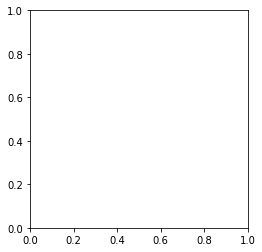

In [15]:
plt.imshow('racoon/images/racoon-94.jpg',cmap='gray')
plt.show()

In [0]:
df = pd.read_csv("train_labels.csv")

### Print the shape of the train dataset

In [35]:
df.shape

(173, 8)

### Declare a variable IMAGE_SIZE = 128 as we will be using MobileNet which will be taking Input shape as 128 * 128 

In [0]:
IMAGE_SIZE = 128 

### With the help of csv.reader write a for loop which can load the train.csv file and store the path, width, height, x0,y0,x1,y1 in induvidual variables. <br>
1. Create a list variable known as 'path' which has all the path for all the training images
2. Create an array 'coords' which has the resized coordinates of the bounding box for the training images

<u>Note:</u> All the training images should be downsampled to 128 * 128 as it is the input shape of MobileNet (which we will be using for Object detection). Hence the corresponding coordinates of the bounding boxes should be changed to match the image dimension of 128 * 128 

In [0]:
with open("train_labels.csv", 'r') as csvfile:
  path =[]
  coords = np.zeros((sum(1 for line in csvfile)-1, 4))
  reader = csv.reader(csvfile, delimiter =',')
  csvfile.seek(0)
  next(reader)
  for col, row in enumerate(reader):
      filename, image_width, image_height,image_class, xmin, ymin, xmax, ymax = row
      coords[col, 0] = int(xmin) * IMAGE_SIZE / int(image_width) # Normalize bounding box by image size
      coords[col, 1] = int(ymin) * IMAGE_SIZE / int(image_height) # Normalize bounding box by image size
      coords[col, 2] = (int(xmax) - int(xmin)) * IMAGE_SIZE / int(image_width) # Normalize bounding box by image size
      coords[col, 3] = (int(ymax) - int(ymin)) * IMAGE_SIZE / int(image_height)
      path.append("racoon/images/"+filename)


### Write a for loop which can load all the training images into a variable 'batch_images' using the paths from the 'paths' variable
<u>Note:</u> Convert the image to RGB scale as the MobileNet accepts 3 channels as inputs   

In [0]:
batch_images = np.zeros((len(path), IMAGE_SIZE, IMAGE_SIZE, 3), dtype=np.float32)
for i,f in enumerate(path):
  img = Image.open(f)
  img = img.resize((IMAGE_SIZE, IMAGE_SIZE))
  img = img.convert('RGB')
  batch_images[i]= preprocess_input(np.array(img, dtype=np.float32))

### Import MobileNet and load MobileNet into a variable named 'model' which takes input shape of 128 * 128 * 3. Freeze all the layers. Add convolution and reshape layers at the end to ensure the output is 4 coordinates

In [0]:
ALPHA =1.0
model = MobileNet(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), include_top=False, alpha=ALPHA)

for layer in model.layers:
  layer.trainable = False

x = model.layers[-1].output
x= Conv2D(4, kernel_size=4, name="coords")(x)
x=Reshape((4,))(x)

model = Model(inputs=model.input, outputs=x)

### Define a custom loss function IoU which calculates Intersection Over Union

In [0]:
def loss(gt,pred):
    intersections = 0
    unions = 0
    diff_width = np.minimum(gt[:,0] + gt[:,2], pred[:,0] + pred[:,2]) - np.maximum(gt[:,0], pred[:,0])
    diff_height = np.minimum(gt[:,1] + gt[:,3], pred[:,1] + pred[:,3]) - np.maximum(gt[:,1], pred[:,1])
    intersection = diff_width * diff_height
    
    # Compute union
    area_gt = gt[:,2] * gt[:,3]
    area_pred = pred[:,2] * pred[:,3]
    union = area_gt + area_pred - intersection

#     Compute intersection and union over multiple boxes
    for j, _ in enumerate(union):
        if union[j] > 0 and intersection[j] > 0 and union[j] >= intersection[j]:
            intersections += intersection[j]
            unions += union[j]

    # Compute IOU. Use epsilon to prevent division by zero
    iou = np.round(intersections / (unions + epsilon()), 4)
    iou = iou.astype(np.float32)
    return iou

def IoU(y_true, y_pred):
    iou = tf.compat.v1.py_func(loss, [y_true, y_pred], tf.float32)
    return iou

### Write model.compile function & model.fit function with: <br>
1. Optimizer = Adam, Loss = 'mse' and metrics = IoU
2. Epochs = 30, batch_size = 32, verbose = 1

In [0]:
EPOCHS = 30
BATCH_SIZE = 32
gt = coords
Verbose = 1

In [77]:
model.compile(optimizer='Adam', loss='mse', metrics=[IoU]) # Regression loss is MSE

model.fit(batch_images,gt,
            epochs=EPOCHS,batch_size = BATCH_SIZE,
            verbose=Verbose)

Train on 173 samples
Epoch 1/30
173/173 [==============================] - 5s 29ms/sample - loss: 2800.4388 - IoU: 0.0976
Epoch 2/30
173/173 [==============================] - 4s 21ms/sample - loss: 651.3794 - IoU: 0.4371
Epoch 3/30
173/173 [==============================] - 4s 21ms/sample - loss: 654.3639 - IoU: 0.5197
Epoch 4/30
173/173 [==============================] - 4s 21ms/sample - loss: 585.2330 - IoU: 0.5413
Epoch 5/30
173/173 [==============================] - 4s 22ms/sample - loss: 345.9305 - IoU: 0.5909
Epoch 6/30
173/173 [==============================] - 4s 21ms/sample - loss: 276.1867 - IoU: 0.5888
Epoch 7/30
173/173 [==============================] - 4s 21ms/sample - loss: 236.1345 - IoU: 0.6053
Epoch 8/30
173/173 [==============================] - 4s 21ms/sample - loss: 193.7212 - IoU: 0.6638
Epoch 9/30
173/173 [==============================] - 4s 21ms/sample - loss: 162.4812 - IoU: 0.6958
Epoch 10/30
173/173 [==============================] - 4s 21ms/sample - loss: 

In [82]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 129, 129, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 64, 64, 32)        864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 64, 64, 32)        128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 64, 64, 32)        0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 64, 64, 32)        288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 64, 64, 32)        128 

### Pick a test image from the given data

In [0]:
import cv2
filename = '/content/drive/My Drive/Colab Notebooks/Residency9-internallab/racoon/images/images/raccoon-99.jpg'
unscaled = cv2.imread(filename) # Original image for display

In [96]:
unscaled.shape

(228, 252, 3)

### Resize the image to 128 * 128 and preprocess the image for the MobileNet model

In [0]:
image_height, image_width, _ = unscaled.shape
image = cv2.resize(unscaled, (IMAGE_SIZE, IMAGE_SIZE)) # Rescaled image to run the network
feat_scaled = preprocess_input(np.array(image, dtype=np.float32))

In [98]:
image.shape

(128, 128, 3)

### Predict the coordinates of the bounding box for the given test image

In [0]:
region = model.predict(x=np.array([feat_scaled]))[0] # Predict the BBox

### Plot the test image using .imshow and draw a boundary box around the image with the coordinates obtained from the model

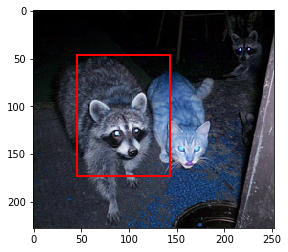

In [100]:
x0 = int(region[0] * image_width / IMAGE_SIZE) # Scale the BBox
y0 = int(region[1] * image_height / IMAGE_SIZE)

x1 = int((region[2]) * image_width / IMAGE_SIZE)
y1 = int((region[3]) * image_height / IMAGE_SIZE)


import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import numpy as np


# Create figure and axes
fig,ax = plt.subplots(1)

# Display the image
ax.imshow(unscaled)

# Create a Rectangle patch
rect = patches.Rectangle((x0, y0), (x1 - x0) , (y1 - y0) , linewidth=2, edgecolor='r', facecolor='none')

# Add the patch to the Axes
ax.add_patch(rect)

plt.show()

# Time Series Prediction using LSTM

### Download Data
Link: https://datamarket.com/data/set/2324/daily-minimum-temperatures-in-melbourne-australia-1981-1990#!ds=2324&display=line

#### Description
Daily minimum temperatures in Melbourne, Australia, 1981-1990

Units: Degrees Celcius

#### Steps before loading
- Rename the column name with temprature values to "Temprature"
- In the last, there is one extra row in the data, remove it by opening the file and save it again.
- There are some values in Temprature column which have a "?" before them, they will give error, remove "?" before them and save the file
- If you don't want to do these steps, just load the data file given by Great Learning.

#### Mount google drive

In [101]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#### Change your present working directory

In [0]:
os.chdir('/content/drive/My Drive/Colab Notebooks/Residency9-internallab')

### Load your data file

In [0]:
df_temp = pd.read_csv("daily-minimum-temperatures-in-me.csv")

In [104]:
df_temp.head()

,Date,Temperature
0,1981-01-01,20.7
1,1981-01-02,17.9
2,1981-01-03,18.8
3,1981-01-04,14.6
4,1981-01-05,15.8


#### Plot data

In [0]:
import seaborn as sns

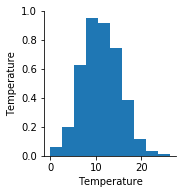

In [107]:
sns.pairplot(df_temp)

#### Descibe your dataframe

In [105]:
df_temp.describe()

,Temperature
count,3650.000000
mean,11.177753
std,4.071837
min,0.000000
25%,8.300000
50%,11.000000
75%,14.000000
max,26.300000


#### Check for null values

In [109]:
df_temp.isna().sum()

Date           0
Temperature    0
dtype: int64

#### Drop null values

In [110]:
df_temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3650 entries, 0 to 3649
Data columns (total 2 columns):
Date           3650 non-null object
Temperature    3650 non-null float64
dtypes: float64(1), object(1)
memory usage: 57.2+ KB


no null values hence no need to drop any.

#### Get the representation of the distribution of data in the form of histogram

(array([ 53., 181., 564., 862., 830., 670., 347., 102.,  32.,   9.]),
 array([ 0.  ,  2.63,  5.26,  7.89, 10.52, 13.15, 15.78, 18.41, 21.04,
        23.67, 26.3 ]),
 <a list of 10 Patch objects>)

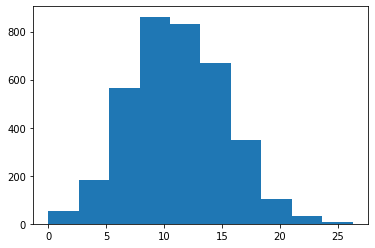

In [111]:
plt.hist(df_temp['Temperature'])

#### Check the maximum and minimum values

In [112]:
np.max(df_temp['Temperature'])

26.3

In [113]:
np.min(df_temp['Temperature'])

0.0

### Normalize the data

In [0]:
from sklearn.preprocessing import StandardScaler

In [0]:
sc = StandardScaler()

#### Check the maximum and minimum values of scaled data

#### Look into some of the scaled values

### Split data into Training and Testing

#### Print train and test size

## Create the sequential data
Map the temprature at a particular time t to the temprature at time t+n, where n is any number you define.

For example: to map tempratures of consecutive days, use t+1, i.e. loop_back = 1

#### Define your function to create dataset

#### Use function to get training and test set

#### Transform the prepared train and test input data into the expected structure using numpy.reshape()

## Define Model

### Define sequntial model, add LSTM layer and compile the model

### Summarize your model

### Train the model

## Make Predictions and Evaluate your model

## Plot the results